In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util import util
from util.logUtil import LOG

Using TensorFlow backend.


In [2]:
# variables
macDir = '/Users/etto/Desktop/tpDatasets/'
winDir = 'E:/SAA_DATA/predictiveMaintenance/'
osDir = winDir
data_folder = '../../storedData/'

# pak alleen de bearings met temperatuur
train_bearings_abbr = ['1_1', '1_2', '2_1', '3_1']
test_bearings_abbr = ['1_4', '1_5', '1_6', '1_7', '2_4', '2_5', '3_3']
train_bearings = ['Bearing{:s}'.format(bearing) for bearing in train_bearings_abbr]
test_bearings = ['Bearing{:s}'.format(bearing) for bearing in test_bearings_abbr]

train_files = ['{:s}{:s}.hd5'.format(data_folder, bearing_name) for bearing_name in train_bearings]
test_files = ['{:s}{:s}.hd5'.format(data_folder, bearing_name) for bearing_name in test_bearings]

# keys to use
keyHSpec = 'horSpec'
keyHT = 'horT'
keyHF = 'horF'
keyVSpec = 'vertSpec'
keyVT = 'vertT'
keyVF = 'vertF'
keyTempTimstamps = 'tempTimestamps'
keyAccTimestamps = 'timestamps'
keyTemps = 'temperature'

# test specificaties
testspecs = [
    ['1_3', 5730],
    ['1_4', 339],
    ['1_5', 1610],
    ['1_6', 1460],
    ['1_7', 7570],
    ['2_3', 7530],
    ['2_4', 1390],
    ['2_5', 3090],
    ['2_6', 1290],
    ['2_7', 580],
    ['3_3', 820]
]

In [122]:
# utility functions
def getDataFrame(bearingPath, key):
    return pd.read_hdf(path_or_buf=bearingPath, key=key)

def plotTrainResults(X, Y, rulModel, history):
    plt.plot(history.history['loss'])
    plt.show()

    plt.figure()
    predictions = rulModel.predict(X)
    plt.plot(predictions)
    plt.plot(Y)
    plt.show()

def getModelName(layersizes, epochs, kenmerk):
    modelname = 'models/rulModel_' + kenmerk + '_'
    for size in layersizes:
        modelname += '{:d}_'.format(size)
    modelname += '1_ep{:d}.h5'.format(epochs)
    return modelname

def evaluate_spectro(modelnames, spectro, RUL_value, plotname=''):
    # True Y values
    nr_samples = len(spectro)
    Y_values = np.array([10 * (nr_samples - i) + RUL_value for i in range(1, nr_samples + 1)])

    models = [load_model(mname) for mname in modelnames]  # type: Model
    predictions = [(model.predict(spectro), np.sqrt(model.evaluate(spectro, Y_values))) for model in models]

    x_ax_values = [10 * i for i in range(nr_samples)]

    nr = 0
    for (prediction, rms) in predictions:
        fig = plt.figure(figsize=(10, 6))
        plt.plot(x_ax_values, prediction,label='Predicted RUL')

        plt.plot(x_ax_values, Y_values,label='Actual RUL')
        plt.title(modelnames[nr] + ' - RMS: {:.0f}'.format(rms))
        plt.ylabel('RUL (s)')
        plt.xlabel('Running Time (s)')
        plt.legend()

        if len(plotname) > 0:
            plt.savefig('plots/' + plotname, bbox_inches='tight', dpi=300)  # 600
        else:
            plt.show()

        nr += 1

def normalizeMatrix(matrix):
    stdS = np.array([np.std(matrix, axis=1)])
#     varS = stdS**2
    meanS = np.array([np.mean(matrix, axis=1)])
    return (matrix - meanS.T) / stdS.T

def maxNormMatrix(matrix):
    return matrix / np.array([np.max(matrix, axis=1)]).T

### bepaal X en Y voor trainen

In [4]:
spectros_train_hor = [getDataFrame(bearingPath, keyHSpec).values for bearingPath in train_files]
spectros_train_vert = [getDataFrame(bearingPath, keyVSpec).values for bearingPath in train_files]

spectros_test_hor = [getDataFrame(bearingPath, keyHSpec).values for bearingPath in test_files]
spectros_test_vert = [getDataFrame(bearingPath, keyVSpec).values for bearingPath in test_files]

X_train = np.concatenate((np.concatenate(spectros_train_hor, axis=0),
                          np.concatenate(spectros_train_vert, axis=0)), 
                          axis=1)
print(np.shape(X_train))

Y_train = []
for spectro in spectros_train_hor:
    nr_samples = len(spectro)
    Y_train_nw = np.array([10 * (nr_samples - i) for i in range(1, nr_samples +1)])
    Y_train = np.append(Y_train, Y_train_nw)
    
print(np.shape(Y_train))

(5100, 2562)
(5100,)


In [5]:
def getDataFrameNorm(bearingPath, key):
    return pd.read_hdf(path_or_buf=bearingPath, key=key)

In [6]:
train_file = train_files[0]
print(train_file)

../../storedData/Bearing1_1.hd5


In [7]:
df = getDataFrame(train_file, keyHSpec)
t = getDataFrame(train_file, keyHT ).values.flatten()
f = getDataFrame(train_file, keyHF).values.flatten()
Sxx = df.values
print(np.shape(t))
print(np.shape(f))
print(np.shape(Sxx))


(2803,)
(1281,)
(2803, 1281)


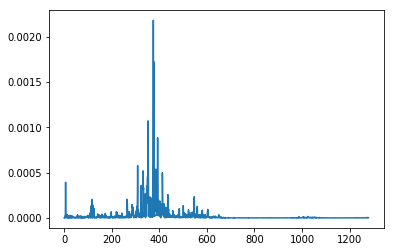

In [8]:
plt.plot(df.values[0])

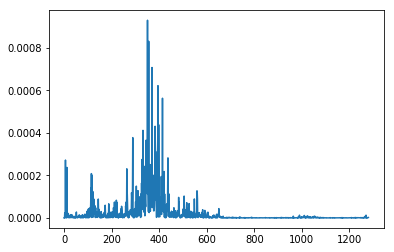

In [9]:
plt.plot(df.values[1])

In [10]:
print(np.std(df.values[0]))

0.000105329936412


In [11]:
print(np.std(df.values[1]))

6.7222071479e-05


In [12]:
len(df.values[0])

1281

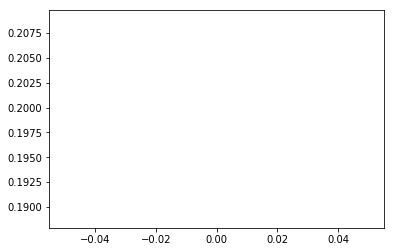

In [13]:
plt.plot(np.max(df.values))

In [14]:
np.max(df.values)

0.19883814896826313

In [15]:
np.std(df.values)

0.0007933651871971099

In [16]:
mxs = np.max(df.values, axis=1)

In [17]:
len(mxs)

2803

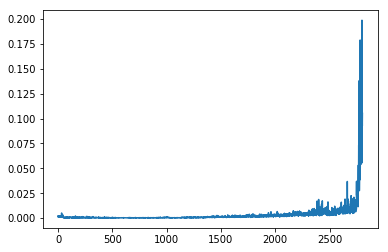

In [18]:
plt.plot(mxs)

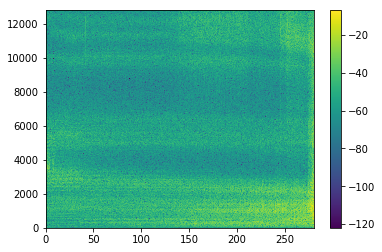

In [19]:
plt.pcolormesh(t,f,10 * np.log10(Sxx.T))
plt.colorbar()
plt.show()

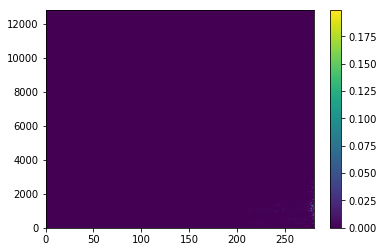

In [20]:
plt.pcolormesh(t,f,Sxx.T)
plt.colorbar()
plt.show()

In [21]:
np.shape(Sxx)

(2803, 1281)

In [110]:
Snorm = normalizeMatrix(Sxx)
print(np.shape(Snorm))

(2803, 1281)


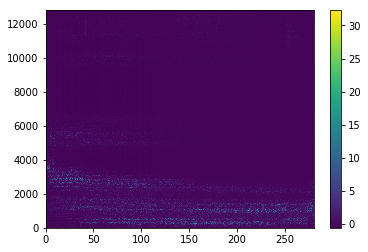

In [111]:
plt.pcolormesh(t,f,Snorm.T)
plt.colorbar()
plt.show()

C:\Users\Etto\Anaconda2\envs\py36DL\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


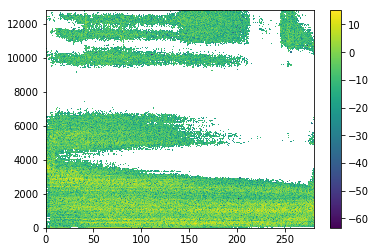

In [115]:
plt.pcolormesh(t,f,10 * np.log10(Snorm.T))
plt.colorbar()
plt.show()

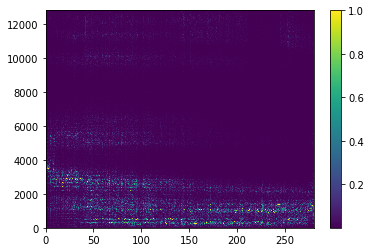

In [123]:
Smaxnorm = maxNormMatrix(Sxx)
plt.pcolormesh(t,f,Smaxnorm.T)
plt.colorbar()
plt.show()

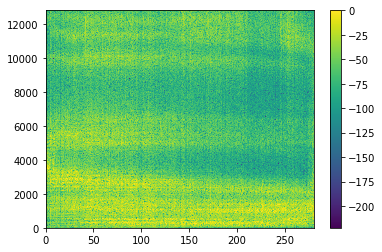

In [124]:
Smaxnorm = maxNormMatrix(Sxx)
plt.pcolormesh(t,f,10*np.log(Smaxnorm.T))
plt.colorbar()
plt.show()

In [60]:
stdS = np.array([np.std(a, axis=1)])
print(stdS)

[[  0.81649658   0.81649658  13.6707311    0.81649658]]


In [61]:
meanS = np.array([np.mean(a, axis=1)])
print(meanS)

[[  2.          11.          40.33333333   4.        ]]


In [62]:
meanMat = np.ones(np.shape(a)) * meanS.T
print(meanMat)

[[  2.           2.           2.        ]
 [ 11.          11.          11.        ]
 [ 40.33333333  40.33333333  40.33333333]
 [  4.           4.           4.        ]]


In [64]:
a - meanS.T

array([[ -1.        ,   0.        ,   1.        ],
       [ -1.        ,   0.        ,   1.        ],
       [  9.66666667, -19.33333333,   9.66666667],
       [  1.        ,  -1.        ,   0.        ]])

In [65]:
a - meanMat

array([[ -1.        ,   0.        ,   1.        ],
       [ -1.        ,   0.        ,   1.        ],
       [  9.66666667, -19.33333333,   9.66666667],
       [  1.        ,  -1.        ,   0.        ]])

In [67]:
(a - meanS.T) / stdS.T

array([[-1.22474487,  0.        ,  1.22474487],
       [-1.22474487,  0.        ,  1.22474487],
       [ 0.70710678, -1.41421356,  0.70710678],
       [ 1.22474487, -1.22474487,  0.        ]])

In [69]:
a

array([[ 1,  2,  3],
       [10, 11, 12],
       [50, 21, 50],
       [ 5,  3,  4]])

In [70]:
normalizeMatrix(a)

array([[-1.22474487,  0.        ,  1.22474487],
       [-1.22474487,  0.        ,  1.22474487],
       [ 0.70710678, -1.41421356,  0.70710678],
       [ 1.22474487, -1.22474487,  0.        ]])

In [78]:
stdS

array([[  0.81649658,   0.81649658,  13.6707311 ,   0.81649658]])

In [79]:
stdS * stdS

array([[   0.66666667,    0.66666667,  186.88888889,    0.66666667]])

In [80]:
stdS**2

array([[   0.66666667,    0.66666667,  186.88888889,    0.66666667]])

In [104]:
matrix = a
stdS = np.array([np.std(matrix, axis=1)])
varS = stdS**2
meanS = np.array([np.mean(matrix, axis=1)])
normd = (matrix - meanS.T) / stdS.T

In [105]:
np.std(normd, axis=1)

array([ 1.,  1.,  1.,  1.])

In [106]:
np.max(Sxx)

0.19883814896826313

In [108]:
normd

array([[-1.22474487,  0.        ,  1.22474487],
       [-1.22474487,  0.        ,  1.22474487],
       [ 0.70710678, -1.41421356,  0.70710678],
       [ 1.22474487, -1.22474487,  0.        ]])

In [107]:
a

array([[ 1,  2,  3],
       [10, 11, 12],
       [50, 21, 50],
       [ 5,  3,  4]])

In [96]:
meanS

array([[  2.        ,  11.        ,  40.33333333,   4.        ]])

In [97]:
stdS

array([[  0.81649658,   0.81649658,  13.6707311 ,   0.81649658]])

In [99]:
mm = a - meanS.T

In [100]:
mm

array([[ -1.        ,   0.        ,   1.        ],
       [ -1.        ,   0.        ,   1.        ],
       [  9.66666667, -19.33333333,   9.66666667],
       [  1.        ,  -1.        ,   0.        ]])

In [116]:
a

array([[ 1,  2,  3],
       [10, 11, 12],
       [50, 21, 50],
       [ 5,  3,  4]])

In [121]:
a / np.array([np.max(a, axis=1)]).T

array([[ 0.33333333,  0.66666667,  1.        ],
       [ 0.83333333,  0.91666667,  1.        ],
       [ 1.        ,  0.42      ,  1.        ],
       [ 1.        ,  0.6       ,  0.8       ]])

In [119]:
mx = np.max(a,axis=1)

In [120]:
mx

array([ 3, 12, 50,  5])